In [2]:
import glob
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone 

from scipy.stats import ks_2samp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from PyALE import ale

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set paths
ROOT = Path('/gpfs/work1/0/wtrcycle/users/jaerts/model_refinement_pub/')
ATTRDIR = f'{ROOT}/catchment_attributes/'
RESULTS = f'{ROOT}/results/'
AUXDIR = f'{ROOT}/aux_data/'
# NOTE this is TEMPORARY
OUTPUT = f'/gpfs/home6/jaerts/temp_model_refinement/rf_feature_selection/ale_data/'

In [4]:
df_streamflow = pd.read_csv(f'{RESULTS}/rf_feature_selection/rf_wflow_pcrglob_streamflow_camels_hydro_attrs.csv', index_col='basin_id')
df_streamflow.loc[df_streamflow['kge_np_wflow'] < -0.42, 'kge_np_wflow'] = -0.42
df_streamflow.loc[df_streamflow['kge_np_pcrglob'] < -0.42, 'kge_np_pcrglob'] = -0.42
df_streamflow['kge_np_delta_wp'] = df_streamflow.kge_np_wflow - df_streamflow.kge_np_pcrglob
df_streamflow = df_streamflow.dropna()

In [5]:
# Load Evaporation Dataframes
df_evaporation = pd.read_csv(f'{RESULTS}/rf_feature_selection/rf_wflow_pcrglob_evaporation_camels_hydro_attrs.csv', index_col='basin_id')
df_evaporation['RRMSE_et_delta_wp'] = df_evaporation.RRMSE_et_wflow - df_evaporation.RRMSE_et_pcrglob
df_evaporation = df_evaporation.dropna()



In [6]:
# Load Soil Moisture Dataframes
df_soilmoisture = pd.read_csv(f'{RESULTS}/rf_feature_selection/rf_wflow_pcrglob_soil_moisture_camels_hydro_attrs.csv', index_col='basin_id')
df_soilmoisture.loc[df_soilmoisture['RRMSE_sm_wflow'] > 10, 'RRMSE_sm_wflow'] = 10
df_soilmoisture.loc[df_soilmoisture['RRMSE_sm_pcrglob'] > 10, 'RRMSE_sm_pcrglob'] = 10
df_soilmoisture['RRMSE_sm_delta_wp'] = df_soilmoisture.RRMSE_sm_wflow - df_soilmoisture.RRMSE_sm_pcrglob
df_soilmoisture = df_soilmoisture.dropna()

# Streamflow

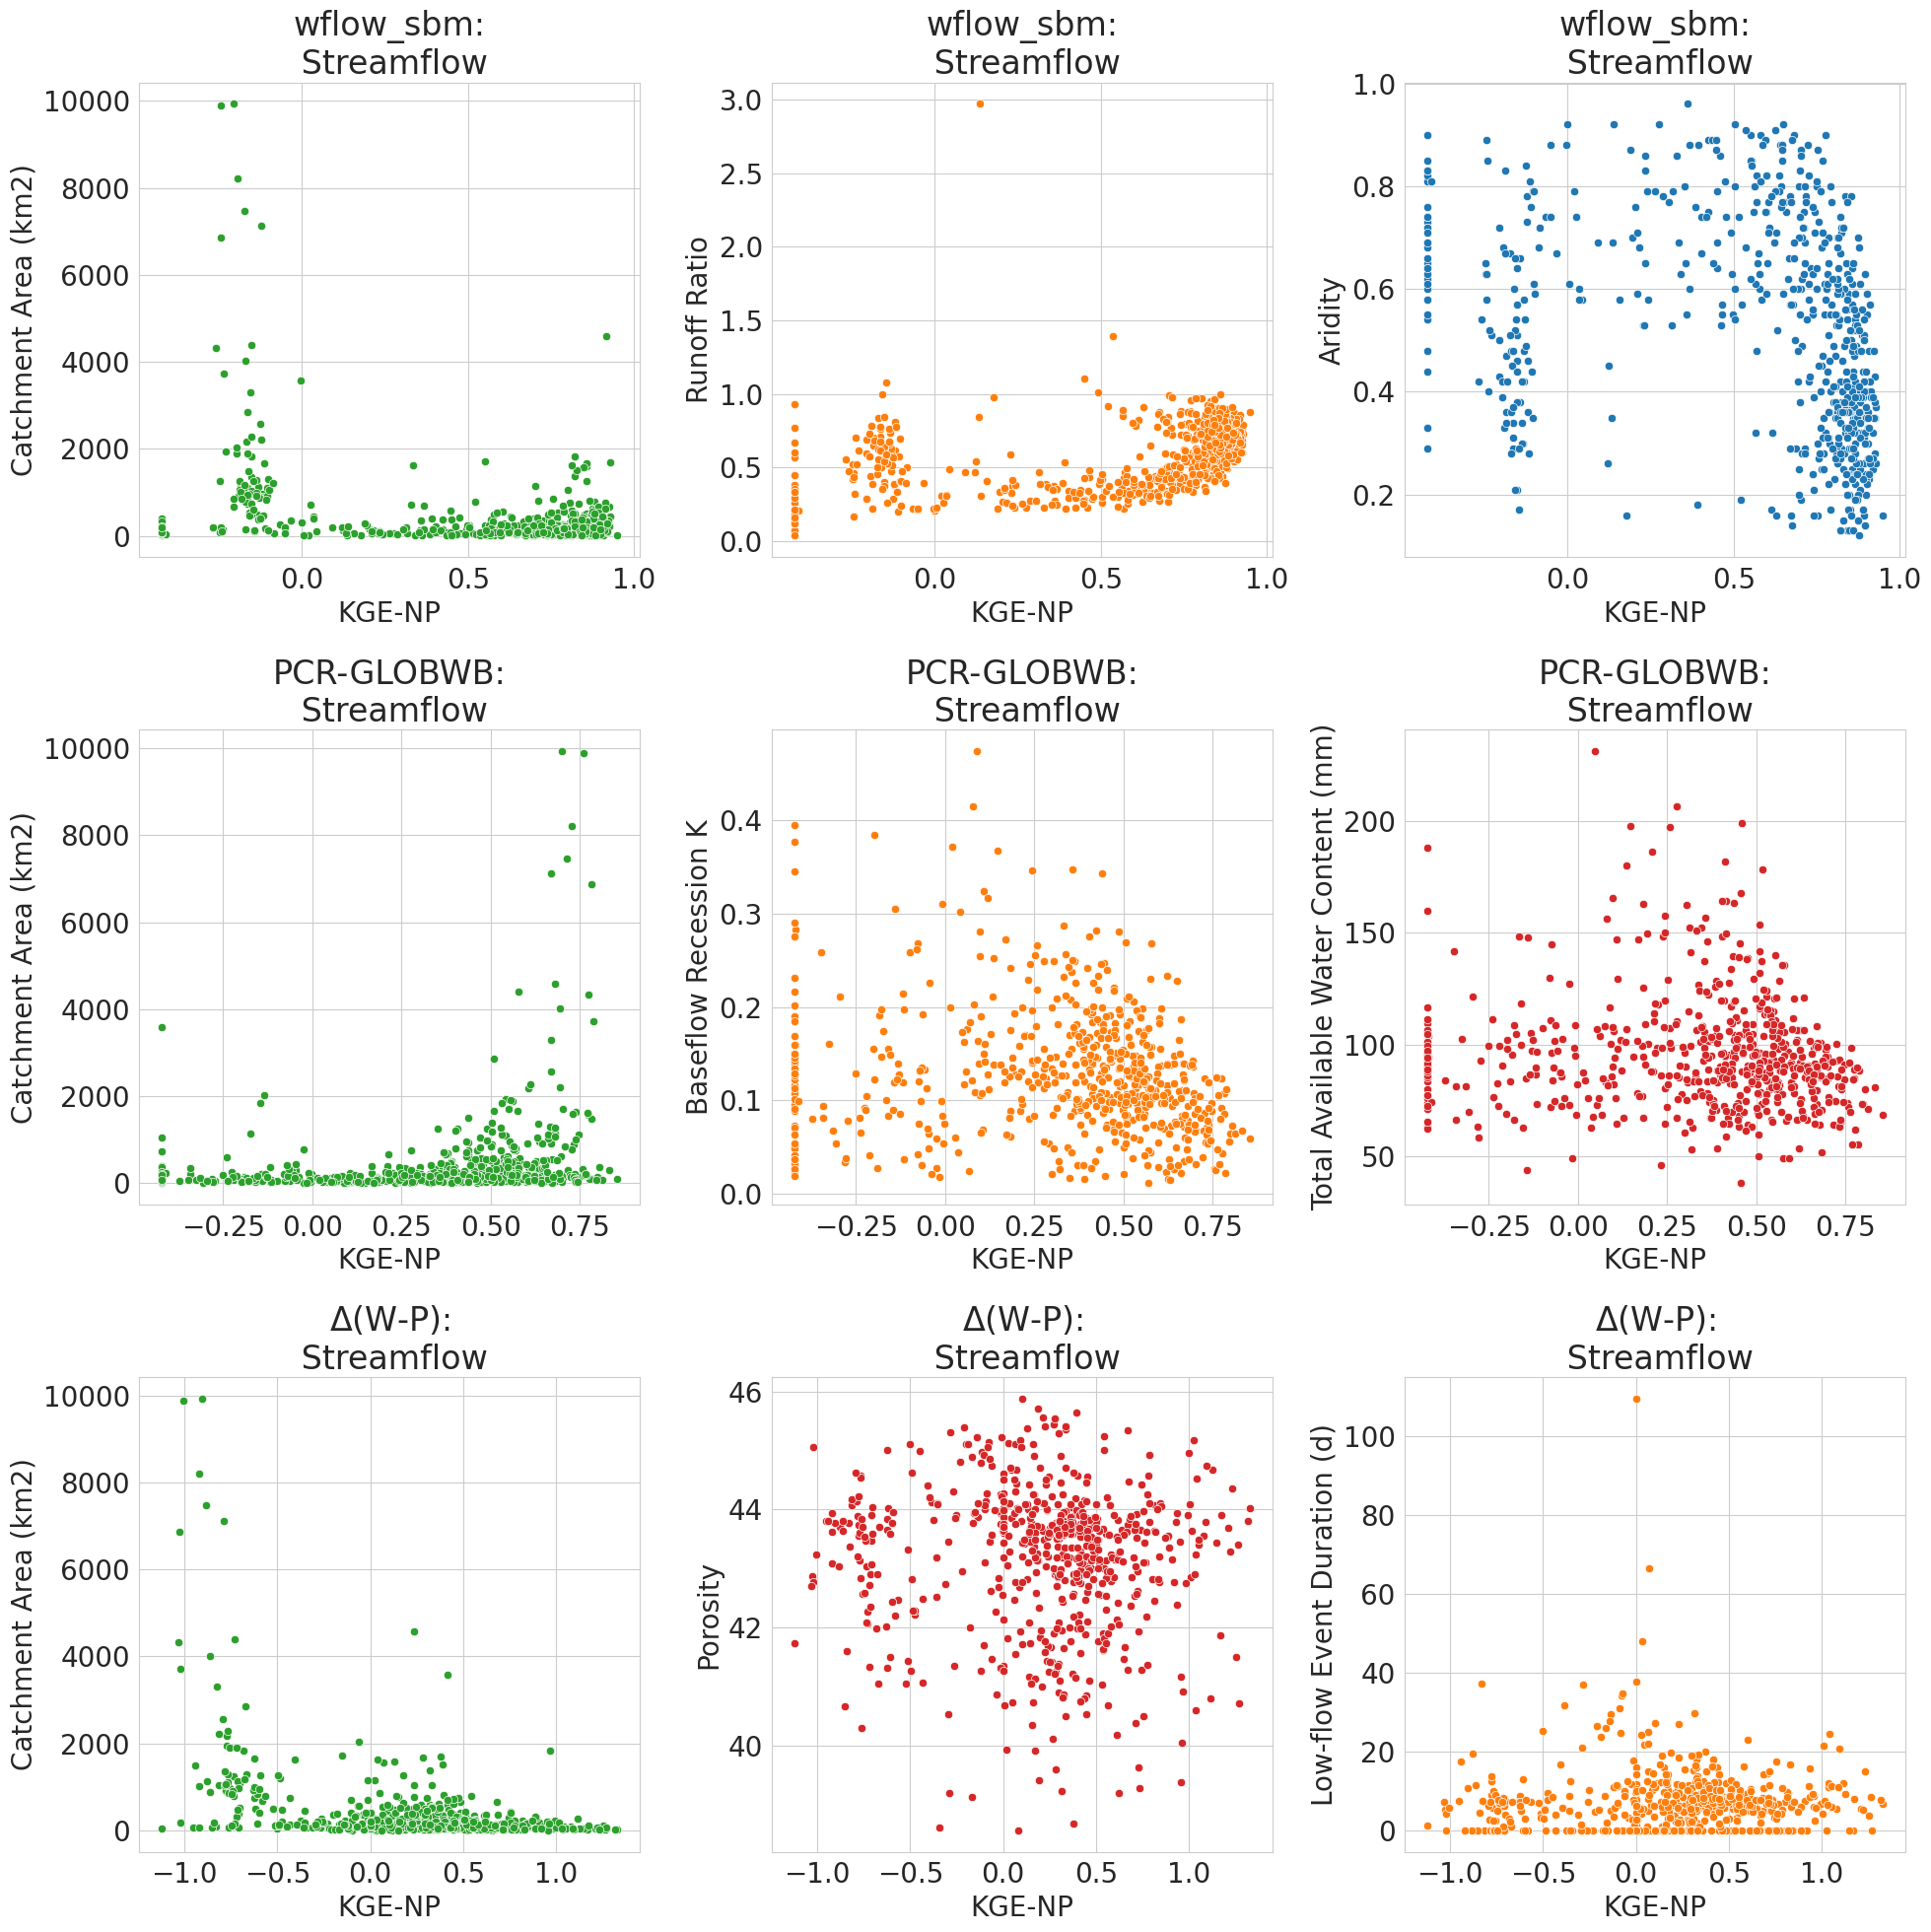

In [32]:
# Figure settings
matplotlib.rcParams.update({'font.size': 20})
sns.set_style("whitegrid")
sns.color_palette("tab10")
colors = {'meteorology': 'tab:blue',
          'hydrology': 'tab:orange',
          'land surface': 'tab:green',
          'subsurface': 'tab:red'}

fig, axes = plt.subplots(3,3, figsize=(20,20))
# WFLOW
ax1 = sns.scatterplot(ax=axes[0, 0], data=df_streamflow, x="kge_np_wflow", y="area", color='tab:green')
ax1.set_ylabel("Catchment Area (km2)") 
ax1.set_xlabel("KGE-NP") 
ax1.set_title("wflow_sbm:\n Streamflow")
ax2 = sns.scatterplot(ax=axes[0, 1], data=df_streamflow, x="kge_np_wflow", y="TotalRR", color='tab:orange')
ax2.set_ylabel("Runoff Ratio") 
ax2.set_xlabel("KGE-NP") 
ax2.set_title("wflow_sbm:\n Streamflow")
ax3 = sns.scatterplot(ax=axes[0, 2], data=df_streamflow, x="kge_np_wflow", y="aridity", color='tab:blue')
ax3.set_ylabel("Aridity") 
ax3.set_xlabel("KGE-NP") 
ax3.set_title("wflow_sbm:\n Streamflow")

#PCR-GLOBWB
ax1 = sns.scatterplot(ax=axes[1, 0], data=df_streamflow, x="kge_np_pcrglob", y="area", color='tab:green')
ax1.set_ylabel("Catchment Area (km2)") 
ax1.set_xlabel("KGE-NP") 
ax1.set_title("PCR-GLOBWB:\n Streamflow")
ax2 = sns.scatterplot(ax=axes[1, 1], data=df_streamflow, x="kge_np_pcrglob", y="BaseflowRecessionK", color='tab:orange')
ax2.set_ylabel("Baseflow Recession K") 
ax2.set_xlabel("KGE-NP") 
ax2.set_title("PCR-GLOBWB:\n Streamflow")
ax3 = sns.scatterplot(ax=axes[1, 2], data=df_streamflow, x="kge_np_pcrglob", y="tawc", color='tab:red')
ax3.set_ylabel("Total Available Water Content (mm)") 
ax3.set_xlabel("KGE-NP") 
ax3.set_title("PCR-GLOBWB:\n Streamflow")

# Delta wp
# kge_np_delta_wp
ax1 = sns.scatterplot(ax=axes[2, 0], data=df_streamflow, x="kge_np_delta_wp", y="area", color='tab:green')
ax1.set_ylabel("Catchment Area (km2)") 
ax1.set_xlabel("KGE-NP") 
ax1.set_title("$\Delta$(W-P):\n Streamflow")
ax2 = sns.scatterplot(ax=axes[2, 1], data=df_streamflow, x="kge_np_delta_wp", y="porosity_cosby", color='tab:red')
ax2.set_ylabel("Porosity") 
ax2.set_xlabel("KGE-NP") 
ax2.set_title("$\Delta$(W-P):\n Streamflow")
ax3 = sns.scatterplot(ax=axes[2, 2], data=df_streamflow, x="kge_np_delta_wp", y="low_Q_dur", color='tab:orange')
ax3.set_ylabel("Low-flow Event Duration (d)") 
ax3.set_xlabel("KGE-NP") 
ax3.set_title("$\Delta$(W-P):\n Streamflow")





plt.tight_layout()
plt.savefig(f'/home/jaerts/model_refinement_master/new_scripts/figures/Appendix_streamflow.png', bbox_inches='tight', dpi=400)

# Evaporation

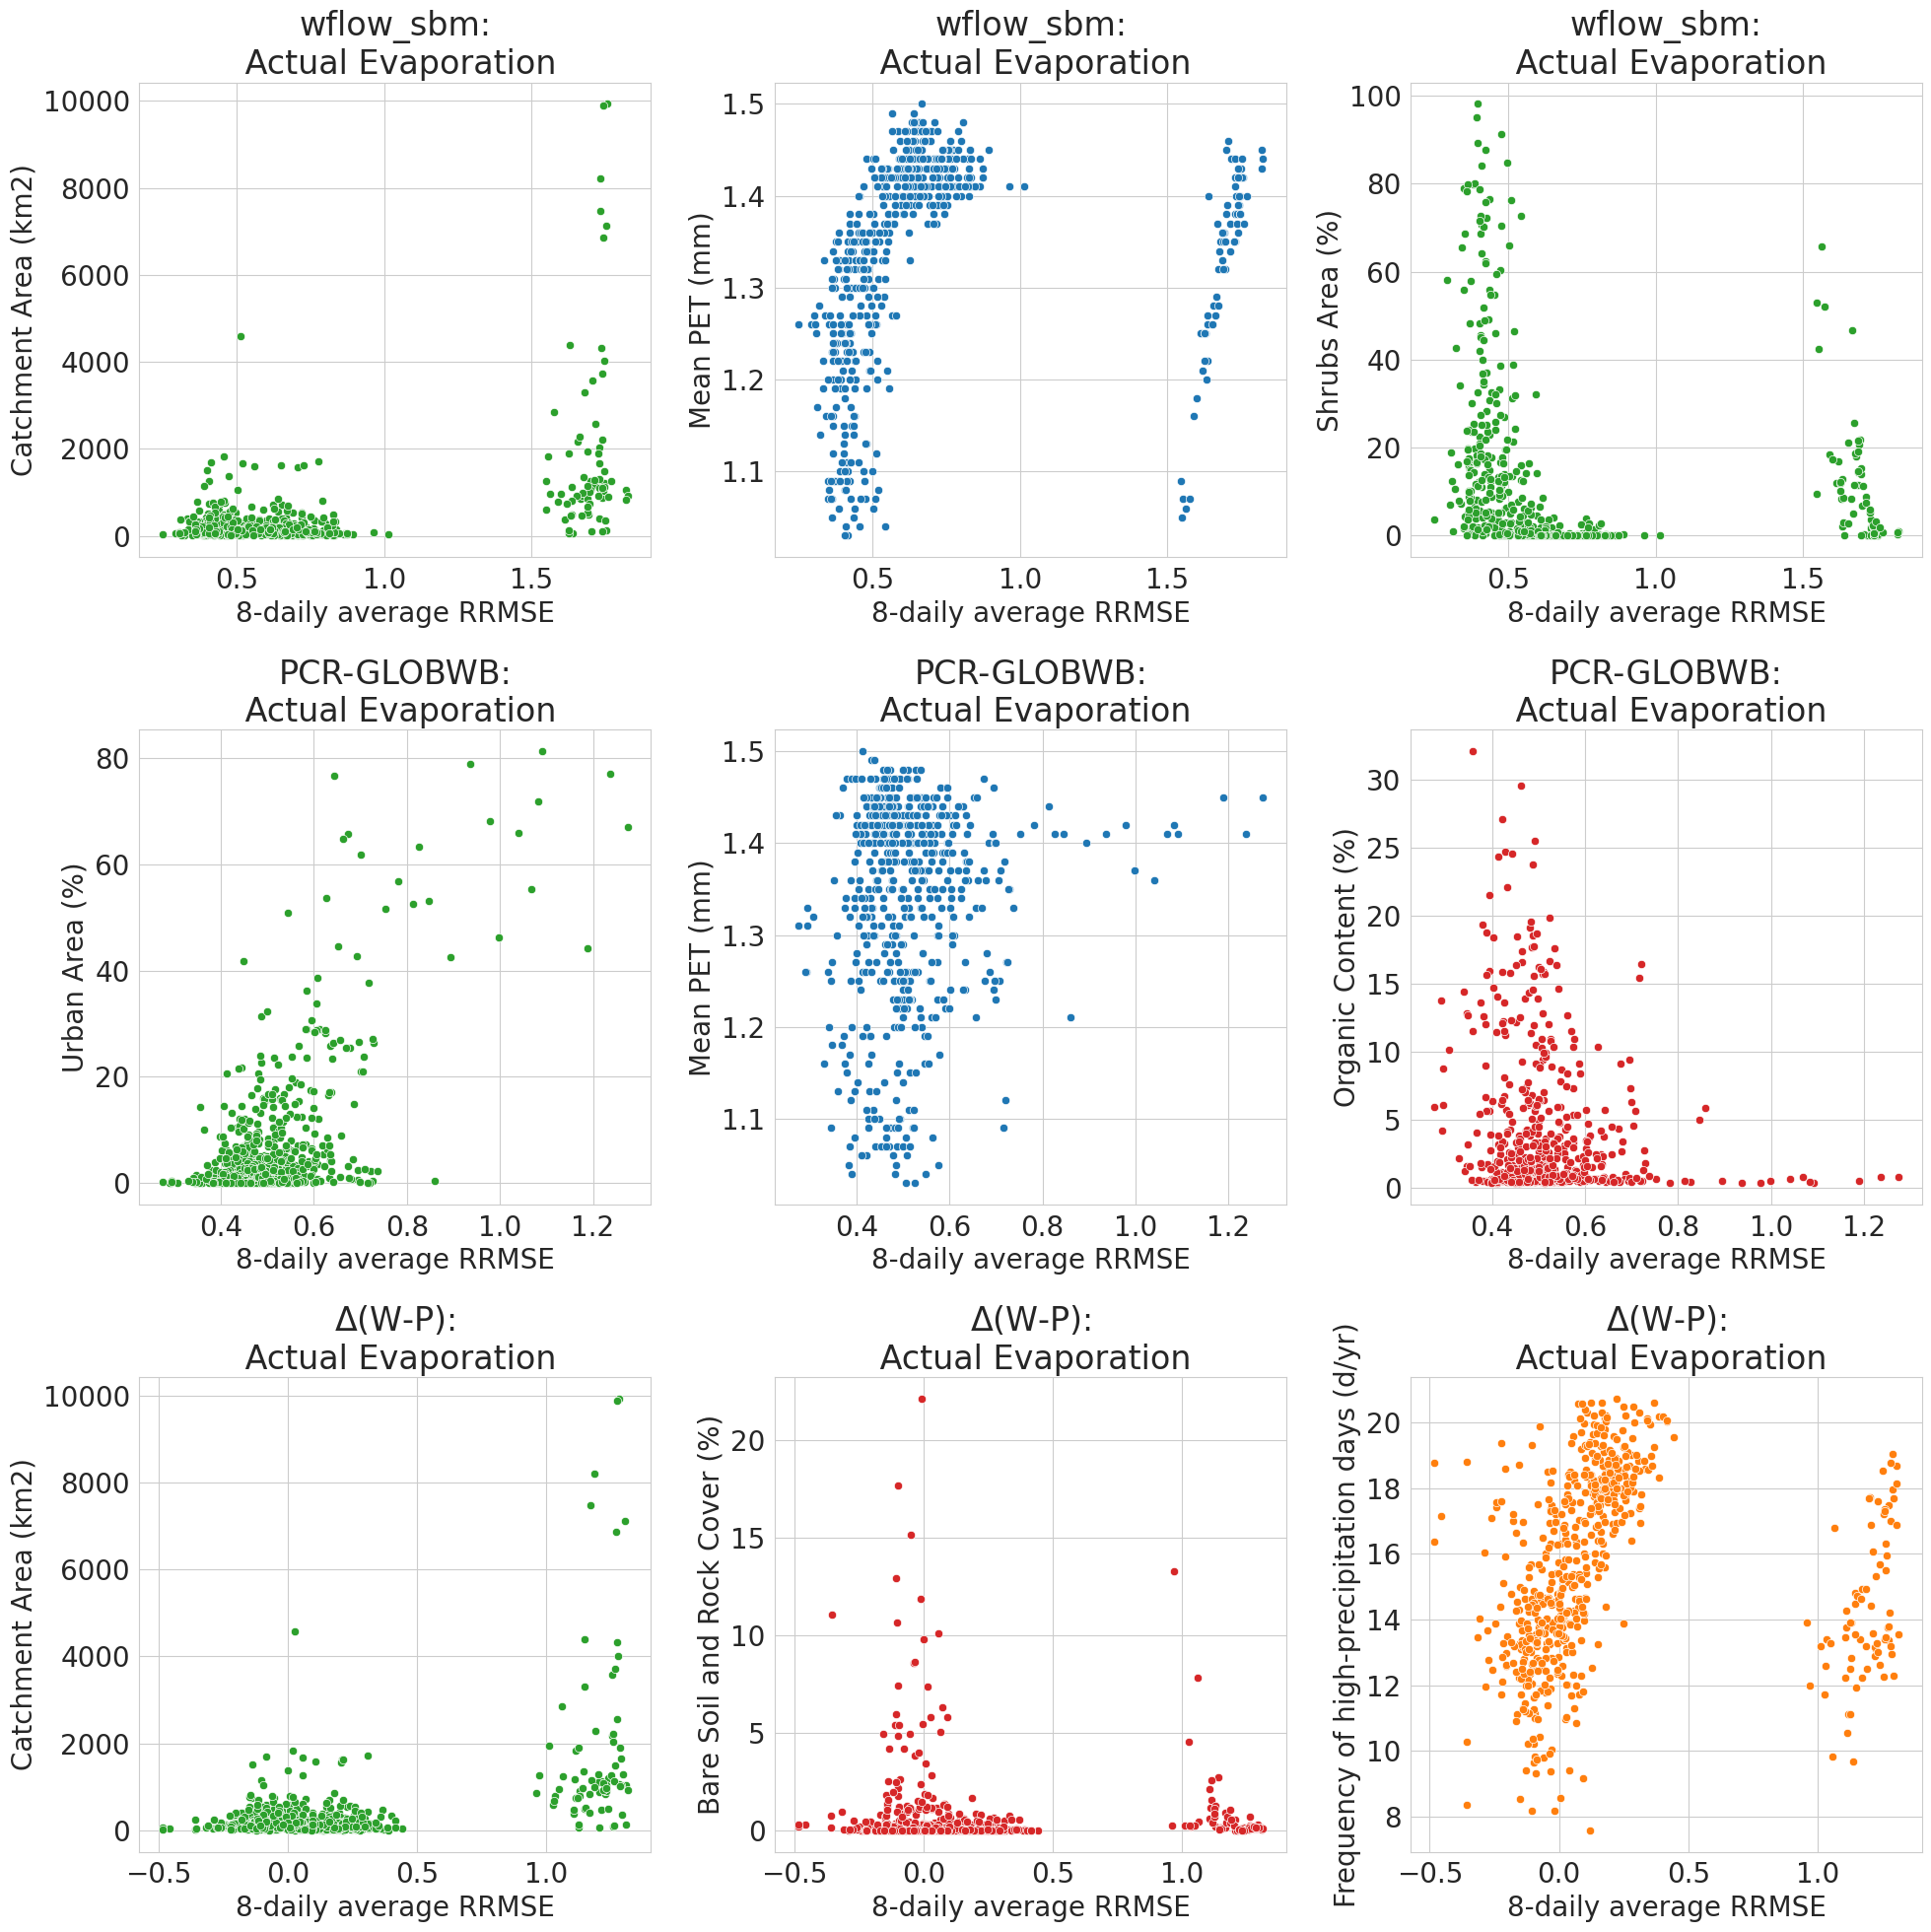

In [11]:
# Figure settings
matplotlib.rcParams.update({'font.size': 20})
sns.set_style("whitegrid")
sns.color_palette("tab10")
colors = {'meteorology': 'tab:blue',
          'hydrology': 'tab:orange',
          'land surface': 'tab:green',
          'subsurface': 'tab:red'}

fig, axes = plt.subplots(3,3, figsize=(20,20))
# WFLOW
ax1 = sns.scatterplot(ax=axes[0, 0], data=df_evaporation, x="RRMSE_et_wflow", y="area", color='tab:green')
ax1.set_ylabel("Catchment Area (km2)") 
ax1.set_xlabel("8-daily average RRMSE") 
ax1.set_title("wflow_sbm:\n Actual Evaporation")
ax2 = sns.scatterplot(ax=axes[0, 1], data=df_evaporation, x="RRMSE_et_wflow", y="pet_mean", color='tab:blue')
ax2.set_ylabel("Mean PET (mm)") 
ax2.set_xlabel("8-daily average RRMSE") 
ax2.set_title("wflow_sbm:\n Actual Evaporation")
ax3 = sns.scatterplot(ax=axes[0, 2], data=df_evaporation, x="RRMSE_et_wflow", y="shrub_perc", color='tab:green')
ax3.set_ylabel("Shrubs Area (%)") 
ax3.set_xlabel("8-daily average RRMSE") 
ax3.set_title("wflow_sbm:\n Actual Evaporation")

#PCR-GLOBWB
ax1 = sns.scatterplot(ax=axes[1, 0], data=df_evaporation, x="RRMSE_et_pcrglob", y="urban_perc", color='tab:green')
ax1.set_ylabel("Urban Area (%)") 
ax1.set_xlabel("8-daily average RRMSE") 
ax1.set_title("PCR-GLOBWB:\n Actual Evaporation")
ax2 = sns.scatterplot(ax=axes[1, 1], data=df_evaporation, x="RRMSE_et_pcrglob", y="pet_mean", color='tab:blue')
ax2.set_ylabel("Mean PET (mm)") 
ax2.set_xlabel("8-daily average RRMSE") 
ax2.set_title("PCR-GLOBWB:\n Actual Evaporation")
ax3 = sns.scatterplot(ax=axes[1, 2], data=df_evaporation, x="RRMSE_et_pcrglob", y="organic_perc", color='tab:red')
ax3.set_ylabel("Organic Content (%)") 
ax3.set_xlabel("8-daily average RRMSE") 
ax3.set_title("PCR-GLOBWB:\n Actual Evaporation")

# Delta wp
# kge_np_delta_wp
ax1 = sns.scatterplot(ax=axes[2, 0], data=df_evaporation, x="RRMSE_et_delta_wp", y="area", color='tab:green')
ax1.set_ylabel("Catchment Area (km2)") 
ax1.set_xlabel("8-daily average RRMSE") 
ax1.set_title("$\Delta$(W-P):\n Actual Evaporation")
ax2 = sns.scatterplot(ax=axes[2, 1], data=df_evaporation, x="RRMSE_et_delta_wp", y="bares_perc", color='tab:red')
ax2.set_ylabel("Bare Soil and Rock Cover (%)") 
ax2.set_xlabel("8-daily average RRMSE") 
ax2.set_title("$\Delta$(W-P):\n Actual Evaporation")
ax3 = sns.scatterplot(ax=axes[2, 2], data=df_evaporation, x="RRMSE_et_delta_wp", y="high_prec_freq", color='tab:orange')
ax3.set_ylabel("Frequency of high-precipitation days (d/yr)") 
ax3.set_xlabel("8-daily average RRMSE") 
ax3.set_title("$\Delta$(W-P):\n Actual Evaporation")





plt.tight_layout()
plt.savefig(f'/home/jaerts/model_refinement_master/new_scripts/figures/Appendix_evaporation.png', bbox_inches='tight', dpi=400)

# Soil Moisture

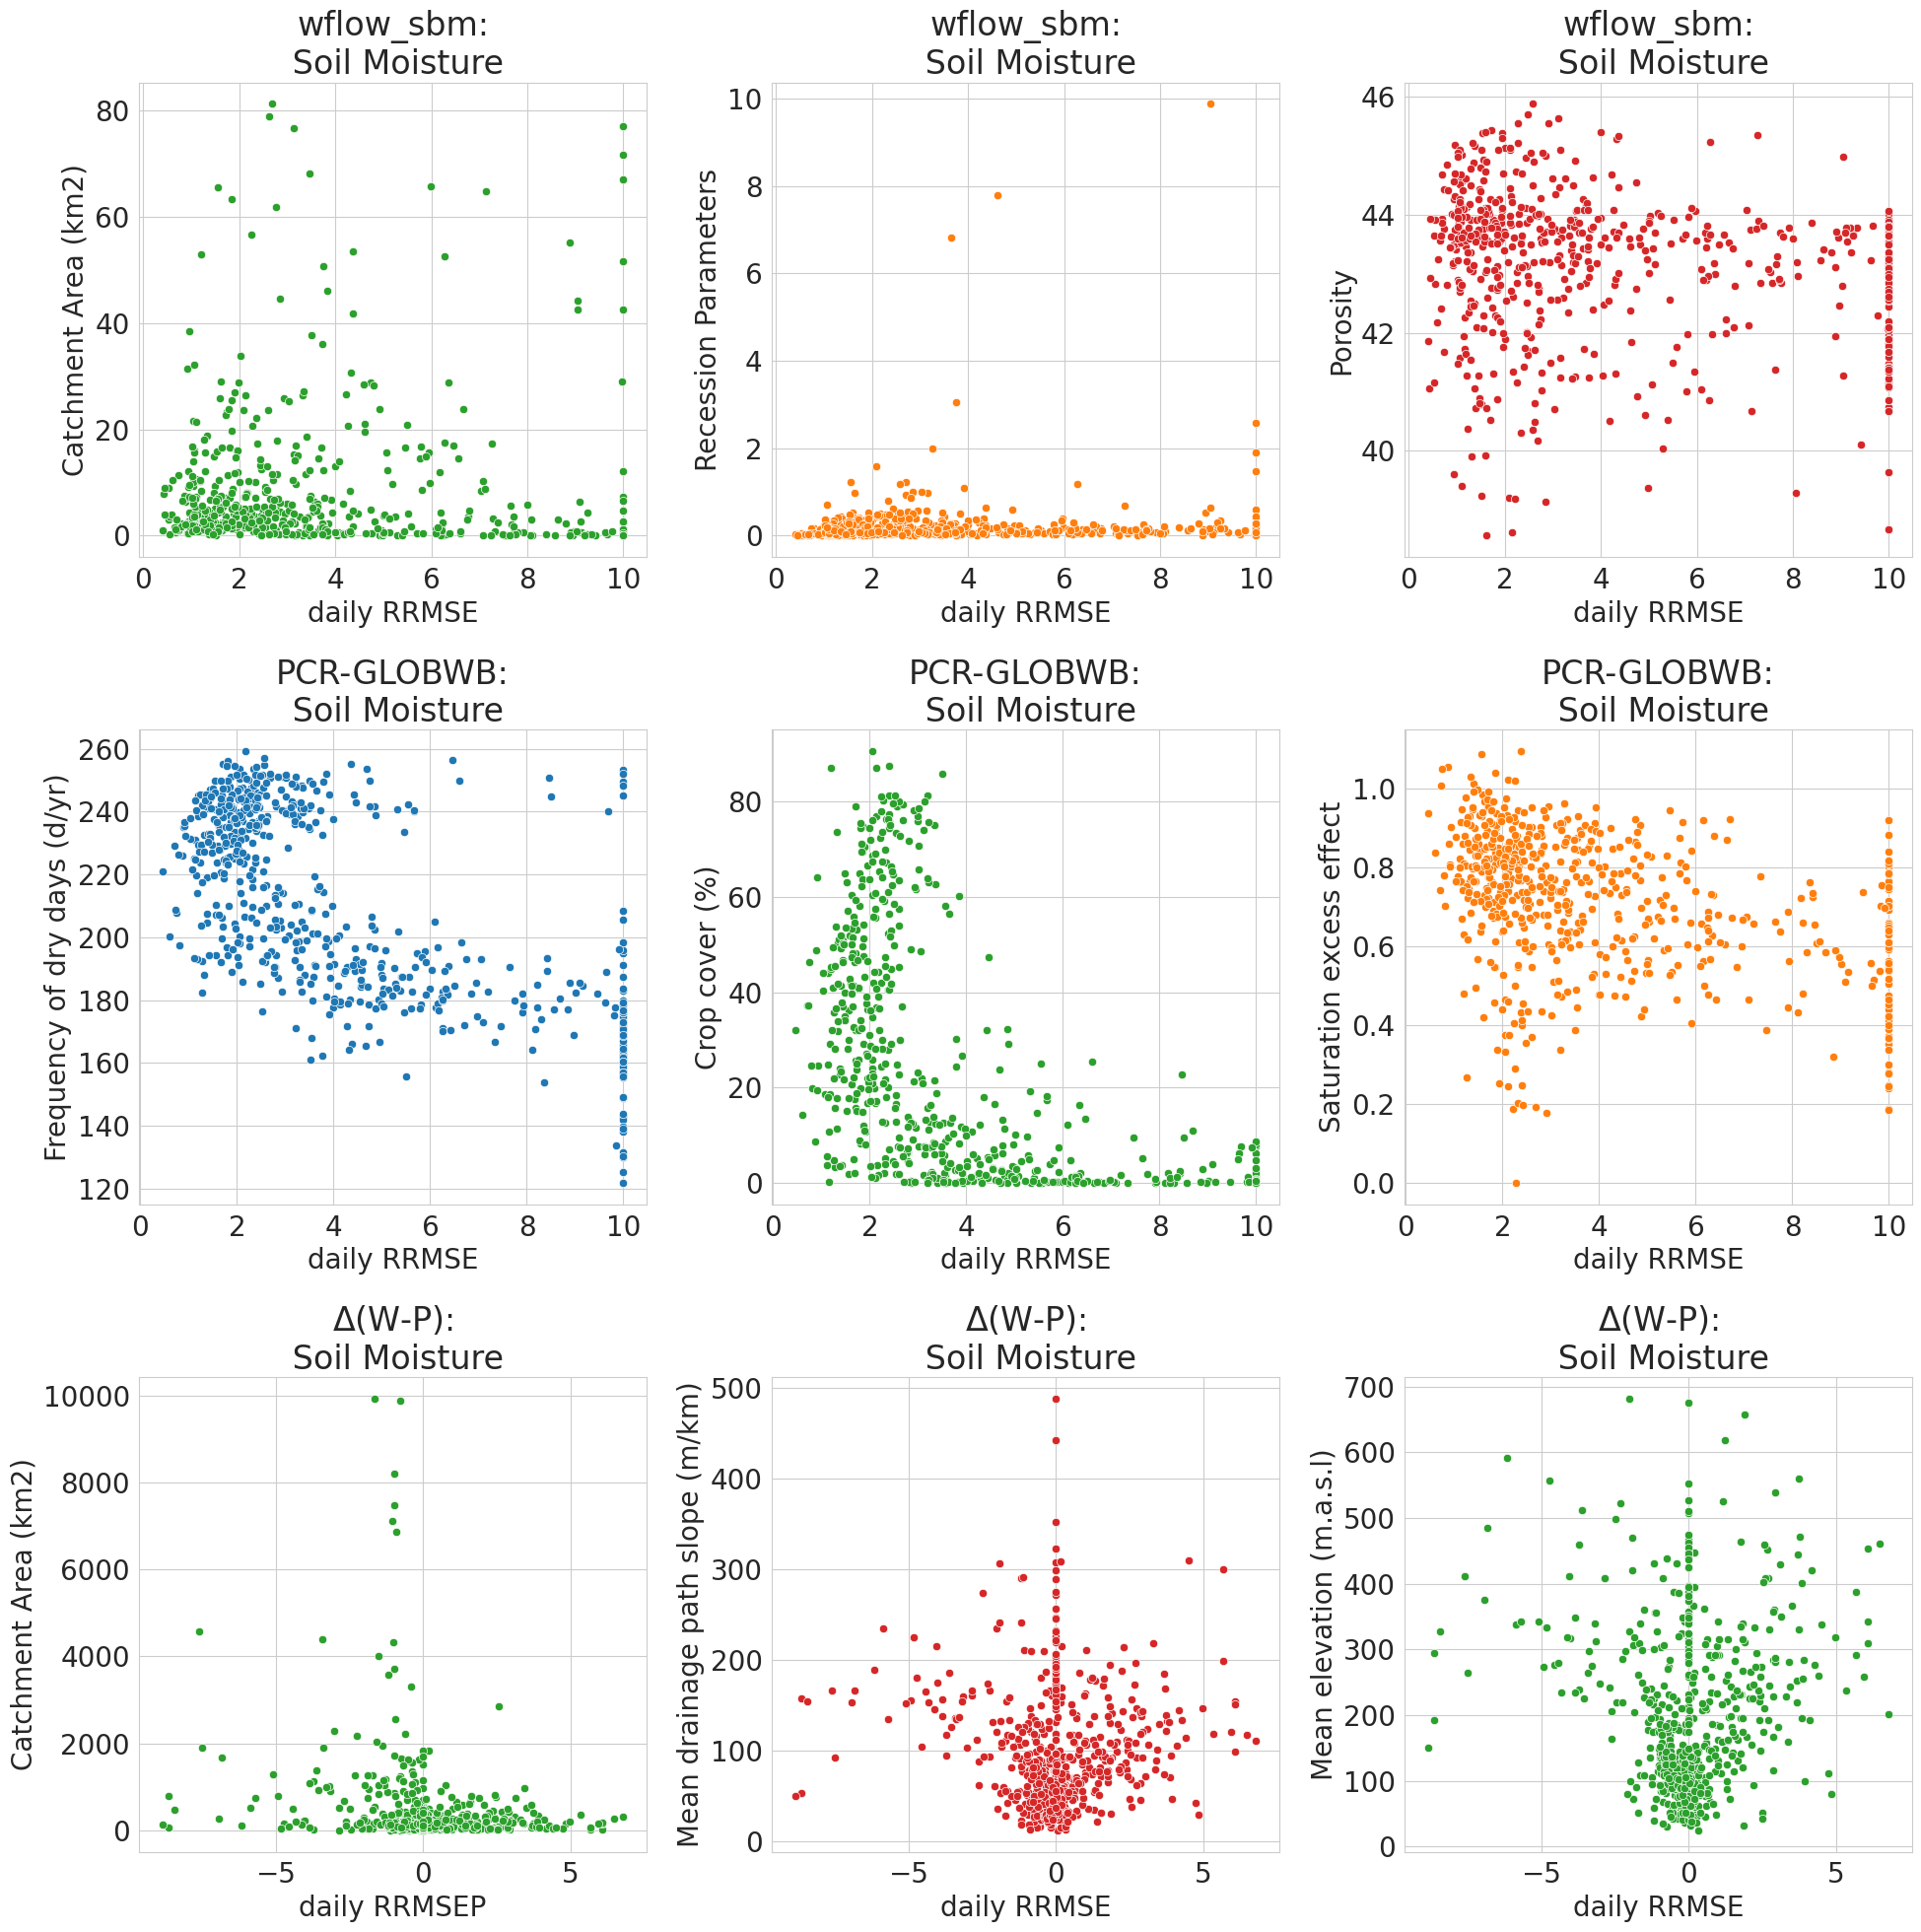

In [13]:
# Figure settings
matplotlib.rcParams.update({'font.size': 20})
sns.set_style("whitegrid")
sns.color_palette("tab10")
colors = {'meteorology': 'tab:blue',
          'hydrology': 'tab:orange',
          'land surface': 'tab:green',
          'subsurface': 'tab:red'}

fig, axes = plt.subplots(3,3, figsize=(20,20))
# WFLOW
ax1 = sns.scatterplot(ax=axes[0, 0], data=df_soilmoisture, x="RRMSE_sm_wflow", y="urban_perc", color='tab:green')
ax1.set_ylabel("Catchment Area (km2)") 
ax1.set_xlabel("daily RRMSE") 
ax1.set_title("wflow_sbm:\n Soil Moisture")
ax2 = sns.scatterplot(ax=axes[0, 1], data=df_soilmoisture, x="RRMSE_sm_wflow", y="RecessionParameters_1", color='tab:orange')
ax2.set_ylabel("Recession Parameters") 
ax2.set_xlabel("daily RRMSE") 
ax2.set_title("wflow_sbm:\n Soil Moisture")
ax3 = sns.scatterplot(ax=axes[0, 2], data=df_soilmoisture, x="RRMSE_sm_wflow", y="porosity_cosby", color='tab:red')
ax3.set_ylabel("Porosity") 
ax3.set_xlabel("daily RRMSE") 
ax3.set_title("wflow_sbm:\n Soil Moisture")

#PCR-GLOBWB
ax1 = sns.scatterplot(ax=axes[1, 0], data=df_soilmoisture, x="RRMSE_sm_pcrglob", y="low_prec_freq", color='tab:blue')
ax1.set_ylabel("Frequency of dry days (d/yr)") 
ax1.set_xlabel("daily RRMSE") 
ax1.set_title("PCR-GLOBWB:\n Soil Moisture")
ax2 = sns.scatterplot(ax=axes[1, 1], data=df_soilmoisture, x="RRMSE_sm_pcrglob", y="crop_perc", color='tab:green')
ax2.set_ylabel("Crop cover (%)") 
ax2.set_xlabel("daily RRMSE") 
ax2.set_title("PCR-GLOBWB:\n Soil Moisture")
ax3 = sns.scatterplot(ax=axes[1, 2], data=df_soilmoisture, x="RRMSE_sm_pcrglob", y="SE_effect", color='tab:orange')
ax3.set_ylabel("Saturation excess effect") 
ax3.set_xlabel("daily RRMSE") 
ax3.set_title("PCR-GLOBWB:\n Soil Moisture")

# Delta wp
# kge_np_delta_wp
ax1 = sns.scatterplot(ax=axes[2, 0], data=df_soilmoisture, x="RRMSE_sm_delta_wp", y="area", color='tab:green')
ax1.set_ylabel("Catchment Area (km2)") 
ax1.set_xlabel("daily RRMSEP") 
ax1.set_title("$\Delta$(W-P):\n Soil Moisture")
ax2 = sns.scatterplot(ax=axes[2, 1], data=df_soilmoisture, x="RRMSE_sm_delta_wp", y="dpsbar", color='tab:red')
ax2.set_ylabel("Mean drainage path slope (m/km)") 
ax2.set_xlabel("daily RRMSE") 
ax2.set_title("$\Delta$(W-P):\n Soil Moisture")
ax3 = sns.scatterplot(ax=axes[2, 2], data=df_soilmoisture, x="RRMSE_sm_delta_wp", y="elev_mean", color='tab:green')
ax3.set_ylabel("Mean elevation (m.a.s.l)") 
ax3.set_xlabel("daily RRMSE") 
ax3.set_title("$\Delta$(W-P):\n Soil Moisture")

plt.tight_layout()
plt.savefig(f'/home/jaerts/model_refinement_master/new_scripts/figures/Appendix_soil_moisture.png', bbox_inches='tight', dpi=400)